In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import multibind as mb
import numpy as np

In [97]:
x = np.array([3,4,5,6])
y = np.array([2,7,8,10])

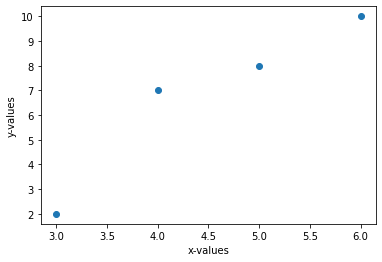

In [98]:
mb.pl.scatter(x, y)

### Simulating data
- We can plug random motifs into a set of sequences,

In [3]:
sim = mb.datasets.simulate_data('____', n_trials=10, seqlen=20)
for s in sim:
    print(s)

AGCCTAGGTAACAT____AT
CTACGCATGCAAGTTG____
TGTTAATAGAAAGA____CA
GATAGGTC____AGCAGTGC
GAGTGGCTACGA____ACCA
TGGCGG____ATAAAGCTGC
GAG____AGGATGTGGTAGA
CCAGCAGGTT____AGGTAT
AC____TCAAAAATTTTGCT
____CAAGCGTGCAATGGTA


In [4]:
sim = mb.datasets.simulate_data('GATA', n_trials=10, seqlen=20)
for s in sim:
    print(s)

CTCGTAATGTTCGAGATATT
GCAACGGCGGGCGTTAGATA
TAATTGCTGATTAAGATAGA
GCCTGTGGGATACAGATTGC
TTAGGCAAATTTGATAGGGC
CTATAAGATATCCCGATTTA
CTCGATAGATCTGAGTCAGT
GTTTTCTAGCGATACGCCAC
ACGATAGCATATCGAACATC
GATAGTTATTTCTATTGCAC


### Simulated data w/continuous values (SELEX) or binary output (ChIP-seq)

In [5]:
motif = 'AGGAACCTA'
# SELEX
x1, y1 = mb.datasets.simulate_xy(motif, n_trials=500, seqlen=20, max_mismatches=5)
# ChIP-seq
x2, y2 = mb.datasets.simulate_xy(motif, n_trials=500, seqlen=100, max_mismatches=2)
y2 = (y2 - y2.min()) / (np.max(y2) - np.min(y2))

x1[:20], y1[:20]

(array(['GAGGAACCTATCGTAATGTTACGT', 'CAGGAACCTACAACGGCGGGACGT',
        'CGTTAGTAGGAACCTATGATACGT', 'TAAAAACGAGAGGAACCTAAACGT',
        'ACAGATTGCAGGAACCTATTACGT', 'TTAGGAACCTAATAAATGATACGT',
        'CCCAGGAACCTAAGGGGATCACGT', 'TGAGGAACCTATTTCTAGCAACGT',
        'GAGCGCCACAAGGAACCTAAACGT', 'TCGAAGGAACCTAGTTATTTACGT',
        'CTATTGAGGAACCTAAACTTACGT', 'AGGAACCTATCGTCGTTTAGACGT',
        'AAGGAACCTAGCCGGGGCTGACGT', 'GTAAGGAACCTAGCCTAGGGACGT',
        'TTAAGGAACCTAAGATGATGACGT', 'CCGAAGGAACCTACTAAAGCACGT',
        'AGGAACCTATTAACTTCTCGACGT', 'CGAGGAACCTAAGCGTTGGCACGT',
        'GGACTCGATAGGAACCTATAACGT', 'TGGGAGGAACCTATGTAACTACGT'],
       dtype='<U24'),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100]))

### Tests of the network with simulated data

In [2]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
import torch.nn as tnn
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [3]:
# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cpu


In [4]:
# motif = 'AGGAACCTA'
motif = 'GATA'
# SELEX
# x1, y1 = mb.datasets.simulate_xy(motif, n_trials=20000, seqlen=20, max_mismatches=5)
# ChIP-seq
x2, y2 = mb.datasets.simulate_xy(motif, n_trials=20000, seqlen=100, max_mismatches=2)
y2 = ((y2 - y2.min()) / (np.max(y2) - np.min(y2))).astype(np.float32)
# data = pd.DataFrame({'seq': x1, 'enr_approx': y1})
data = pd.DataFrame({'seq': x2, 'target': y2})
# divide in train and test data -- copied from above, organize differently!
test_dataframe = data.sample(frac=0.01)
train_dataframe = data.drop(test_dataframe.index)
train_100_dataframe = train_dataframe.sample(n=100)
train_10_dataframe = train_100_dataframe.sample(n=10)
train_4_dataframe = train_10_dataframe.sample(n=4)
train_1_dataframe = train_4_dataframe.sample(n=1)

test_dataframe.index = range(len(test_dataframe))
train_dataframe.index = range(len(train_dataframe))
train_1_dataframe.index = range(1)
train_4_dataframe.index = range(4)
train_10_dataframe.index = range(10)
train_100_dataframe.index = range(100)

# create datasets and dataloaders
train_data = mb.tl.ChipSeqDataset(data_frame=train_dataframe)
train_loader = tdata.DataLoader(dataset=train_data, batch_size=256, shuffle=True)
test_data = mb.tl.ChipSeqDataset(data_frame=test_dataframe)
test_loader = tdata.DataLoader(dataset=test_data, batch_size=1, shuffle=False)
train_1_data = mb.tl.ChipSeqDataset(data_frame=train_1_dataframe)
train_1_loader = tdata.DataLoader(dataset=train_1_data, batch_size=1, shuffle=False)
train_4_data = mb.tl.ChipSeqDataset(data_frame=train_4_dataframe)
train_4_loader = tdata.DataLoader(dataset=train_4_data, batch_size=4, shuffle=False)
train_10_data = mb.tl.ChipSeqDataset(data_frame=train_10_dataframe)
train_10_loader = tdata.DataLoader(dataset=train_10_data, batch_size=10, shuffle=False)
train_100_data = mb.tl.ChipSeqDataset(data_frame=train_100_dataframe)
train_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=10, shuffle=True)
test_100_loader = tdata.DataLoader(dataset=train_100_data, batch_size=1, shuffle=False)

In [12]:
train_4_dataframe

,seq,target
0,TCCGACTCTGTATTTTGGTCGCAGACGGAGATTAGCCTTTACTAGG...,0.0
1,ATCTTTATCGGTTTCGGTTGGTAAGGTCCCATCGGTCGCGATAGCT...,0.0
2,ATGAACTCAAGGCAACGCTGGTATAGGCACTAATACTGGACAAGCG...,0.0
3,TCTTAAACAATACAGTTAGCCCACCTCGTAAATAACTCAAGTACTG...,1.0


In [4]:
train_loader, test_loader = create_simulated_data()
# train_loader, test_loader = create_datasets('data/countTable.0.CTCF_r3.tsv.gz')

net = mb.tl.Network().to(device)  # Create an instance of the network in memory (potentially GPU memory).
optimiser = topti.Adam(net.parameters(), lr=0.001)  # Minimise the loss using the Adam algorithm.
# criterion = PoissonLoss()
# criterion = tnn.PoissonNLLLoss()
criterion = tnn.BCELoss()
# criterion = tnn.BCEWithLogitsLoss()

In [5]:
net = mb.tl.Network().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.001)
criterion = tnn.BCELoss()

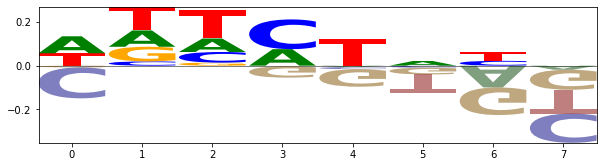

In [6]:
mb.tl.create_logo(net)

In [8]:
sns.heatmap(m, cmap='Reds', vmin=0)

NameError: name 'm' is not defined

In [137]:
# optimiser = topti.Adam(net.parameters(), lr=0.001)
mb.tl.train_network(net, train_10_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.041
Epoch:  2, Loss: 0.041
Epoch:  3, Loss: 0.041
Epoch:  4, Loss: 0.041
Epoch:  5, Loss: 0.041
Epoch:  6, Loss: 0.041
Epoch:  7, Loss: 0.041
Epoch:  8, Loss: 0.041
Epoch:  9, Loss: 0.041
Epoch: 10, Loss: 0.041
Epoch: 11, Loss: 0.041
Epoch: 12, Loss: 0.041
Epoch: 13, Loss: 0.041
Epoch: 14, Loss: 0.041
Epoch: 15, Loss: 0.041
Epoch: 16, Loss: 0.041
Epoch: 17, Loss: 0.040
Epoch: 18, Loss: 0.040
Epoch: 19, Loss: 0.040
Epoch: 20, Loss: 0.040
Epoch: 21, Loss: 0.040
Epoch: 22, Loss: 0.040
Epoch: 23, Loss: 0.040
Epoch: 24, Loss: 0.040
Epoch: 25, Loss: 0.040
Epoch: 26, Loss: 0.040
Epoch: 27, Loss: 0.040
Epoch: 28, Loss: 0.040
Epoch: 29, Loss: 0.040
Epoch: 30, Loss: 0.040
Epoch: 31, Loss: 0.040
Epoch: 32, Loss: 0.040
Epoch: 33, Loss: 0.040
Epoch: 34, Loss: 0.040
Epoch: 35, Loss: 0.040
Epoch: 36, Loss: 0.040
Epoch: 37, Loss: 0.040
Epoch: 38, Loss: 0.040
Epoch: 39, Loss: 0.040
Epoch: 40, Loss: 0.040
Epoch: 41, Loss: 0.040
Epoch: 42, Loss: 0.040
Epoch: 43, Loss: 0.040
Epoch: 44, 

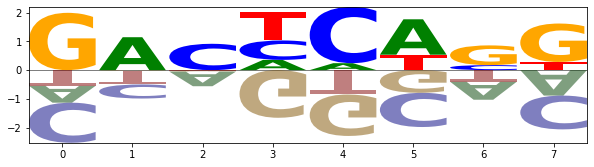

In [139]:
mb.tl.create_logo(net)

In [45]:
train_10_dataframe

,seq,target
0,GCGTCTTGAAATTTCATGTGTTTCACGATCTTTAGCGGCCGAGGTG...,1.0
1,TCCCTATAGTACCGCTCGTGTGCGTCTCAATGCGTATTTTAGACGT...,0.0
2,CCGCAGTCGGGGTCGGTAGGCCAACCAAGTCATATTCTGATCACAG...,0.0
3,ATCTTTATCGGTTTCGGTTGGTAAGGTCCCATCGGTCGCGATAGCT...,0.0
4,CTGACTCTGCGGCGAGGAGAAAAGAATGCACGGGTTGGATAATTGT...,1.0
5,GAGTCGCCGTTCTGGAGACATGTTGGACCGCTTCTTGTCTGGGATA...,1.0
6,TCTTAAACAATACAGTTAGCCCACCTCGTAAATAACTCAAGTACTG...,1.0
7,GCATGTGCGGAAGATCCATATCCAAACTTCATTGCAACTGTGCAGG...,0.0
8,ATGAACTCAAGGCAACGCTGGTATAGGCACTAATACTGGACAAGCG...,0.0
9,TCCGACTCTGTATTTTGGTCGCAGACGGAGATTAGCCTTTACTAGG...,0.0


In [138]:
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(train_10_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        print(target)
        print(output)

tensor([1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])
tensor([9.1489e-01, 7.6725e-05, 6.0248e-02, 5.5136e-02, 9.6415e-01, 9.9875e-01,
        9.3349e-01, 2.9766e-02, 3.0815e-02, 1.2235e-02])


In [255]:
# I had to use a smaller learning rate than for 10 samples, because otherwise the loss wouldn't go down at all
# However, also with this, it needed thousands of epochs for the loss to go down a little bit.
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
mb.tl.train_network(net, train_100_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.598
Epoch:  2, Loss: 0.595
Epoch:  3, Loss: 0.596
Epoch:  4, Loss: 0.596
Epoch:  5, Loss: 0.596
Epoch:  6, Loss: 0.598
Epoch:  7, Loss: 0.597
Epoch:  8, Loss: 0.596
Epoch:  9, Loss: 0.597
Epoch: 10, Loss: 0.597
Epoch: 11, Loss: 0.598
Epoch: 12, Loss: 0.597
Epoch: 13, Loss: 0.593
Epoch: 14, Loss: 0.601
Epoch: 15, Loss: 0.599
Epoch: 16, Loss: 0.597
Epoch: 17, Loss: 0.597
Epoch: 18, Loss: 0.596
Epoch: 19, Loss: 0.597
Epoch: 20, Loss: 0.596
Epoch: 21, Loss: 0.595
Epoch: 22, Loss: 0.596
Epoch: 23, Loss: 0.595
Epoch: 24, Loss: 0.596
Epoch: 25, Loss: 0.595
Epoch: 26, Loss: 0.596
Epoch: 27, Loss: 0.600
Epoch: 28, Loss: 0.596
Epoch: 29, Loss: 0.595
Epoch: 30, Loss: 0.599
Epoch: 31, Loss: 0.597
Epoch: 32, Loss: 0.595
Epoch: 33, Loss: 0.596
Epoch: 34, Loss: 0.596
Epoch: 35, Loss: 0.613
Epoch: 36, Loss: 0.594
Epoch: 37, Loss: 0.597
Epoch: 38, Loss: 0.596
Epoch: 39, Loss: 0.596
Epoch: 40, Loss: 0.596
Epoch: 41, Loss: 0.595
Epoch: 42, Loss: 0.596
Epoch: 43, Loss: 0.597
Epoch: 44, 

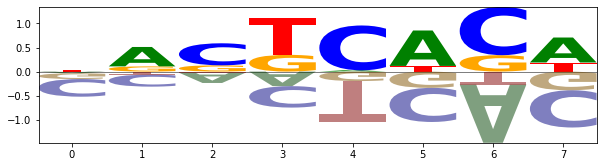

In [256]:
mb.tl.create_logo(net)

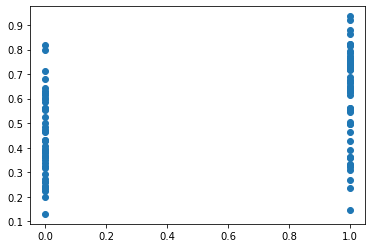

In [257]:
all_targets, all_outputs = [], []
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_100_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

In [283]:
np.median(np.array(all_outputs)[np.array(all_targets) == 1])

0.64321023

In [284]:
np.median(np.array(all_outputs)[np.array(all_targets) == 0])

0.42768595

<AxesSubplot:>

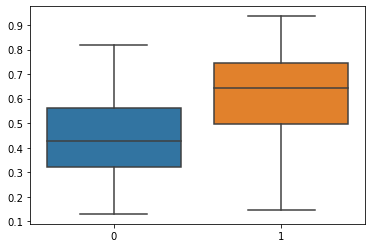

In [287]:
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [288]:
# Another try with a newly initialized network
net = mb.tl.Network().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.0001)
criterion = tnn.BCELoss()

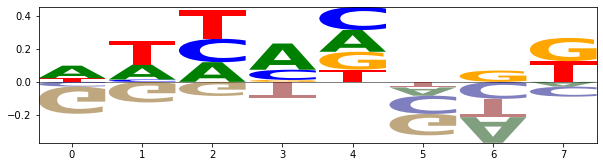

In [289]:
mb.tl.create_logo(net)

In [290]:
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
mb.tl.train_network(net, train_100_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 29.993
Epoch:  2, Loss: 24.021
Epoch:  3, Loss: 17.905
Epoch:  4, Loss: 15.125
Epoch:  5, Loss: 7.193
Epoch:  6, Loss: 6.769
Epoch:  7, Loss: 5.441
Epoch:  8, Loss: 4.975
Epoch:  9, Loss: 4.526
Epoch: 10, Loss: 4.093
Epoch: 11, Loss: 3.635
Epoch: 12, Loss: 3.213
Epoch: 13, Loss: 2.820
Epoch: 14, Loss: 2.409
Epoch: 15, Loss: 2.067
Epoch: 16, Loss: 1.753
Epoch: 17, Loss: 1.498
Epoch: 18, Loss: 1.318
Epoch: 19, Loss: 1.192
Epoch: 20, Loss: 1.116
Epoch: 21, Loss: 1.089
Epoch: 22, Loss: 1.060
Epoch: 23, Loss: 1.052
Epoch: 24, Loss: 1.049
Epoch: 25, Loss: 1.048
Epoch: 26, Loss: 1.045
Epoch: 27, Loss: 1.045
Epoch: 28, Loss: 1.045
Epoch: 29, Loss: 1.042
Epoch: 30, Loss: 1.040
Epoch: 31, Loss: 1.038
Epoch: 32, Loss: 1.039
Epoch: 33, Loss: 1.035
Epoch: 34, Loss: 1.038
Epoch: 35, Loss: 1.031
Epoch: 36, Loss: 1.030
Epoch: 37, Loss: 1.030
Epoch: 38, Loss: 1.031
Epoch: 39, Loss: 1.025
Epoch: 40, Loss: 1.023
Epoch: 41, Loss: 1.021
Epoch: 42, Loss: 1.020
Epoch: 43, Loss: 1.019
Epoch: 

In [307]:
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
mb.tl.train_network(net, train_100_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 0.623
Epoch:  2, Loss: 0.623
Epoch:  3, Loss: 0.624
Epoch:  4, Loss: 0.622
Epoch:  5, Loss: 0.623
Epoch:  6, Loss: 0.623
Epoch:  7, Loss: 0.624
Epoch:  8, Loss: 0.624
Epoch:  9, Loss: 0.623
Epoch: 10, Loss: 0.627
Epoch: 11, Loss: 0.623
Epoch: 12, Loss: 0.625
Epoch: 13, Loss: 0.623
Epoch: 14, Loss: 0.623
Epoch: 15, Loss: 0.624
Epoch: 16, Loss: 0.629
Epoch: 17, Loss: 0.624
Epoch: 18, Loss: 0.623
Epoch: 19, Loss: 0.626
Epoch: 20, Loss: 0.624
Epoch: 21, Loss: 0.629
Epoch: 22, Loss: 0.621
Epoch: 23, Loss: 0.623
Epoch: 24, Loss: 0.624
Epoch: 25, Loss: 0.622
Epoch: 26, Loss: 0.623
Epoch: 27, Loss: 0.625
Epoch: 28, Loss: 0.624
Epoch: 29, Loss: 0.622
Epoch: 30, Loss: 0.622
Epoch: 31, Loss: 0.625
Epoch: 32, Loss: 0.623
Epoch: 33, Loss: 0.622
Epoch: 34, Loss: 0.623
Epoch: 35, Loss: 0.623
Epoch: 36, Loss: 0.624
Epoch: 37, Loss: 0.622
Epoch: 38, Loss: 0.622
Epoch: 39, Loss: 0.623
Epoch: 40, Loss: 0.622
Epoch: 41, Loss: 0.624
Epoch: 42, Loss: 0.623
Epoch: 43, Loss: 0.623
Epoch: 44, 

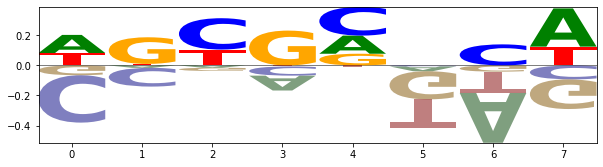

In [308]:
mb.tl.create_logo(net)

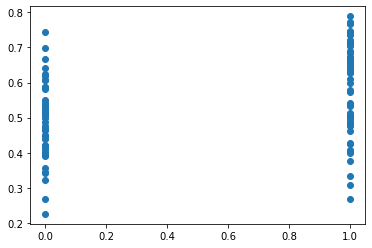

In [309]:
all_targets, all_outputs = [], []
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_100_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))

In [310]:
np.median(np.array(all_outputs)[np.array(all_targets) == 1])

0.6303624

In [311]:
np.median(np.array(all_outputs)[np.array(all_targets) == 0])

0.4752125

<AxesSubplot:>

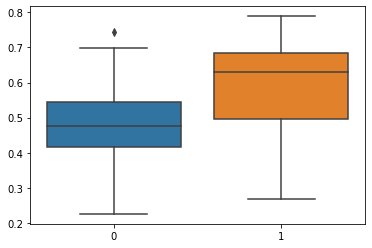

In [312]:
sns.boxplot(data=(np.array(all_outputs)[np.array(all_targets) == 0], np.array(all_outputs)[np.array(all_targets) == 1]))

In [314]:
y, y_pred = np.array(all_targets), np.array(all_outputs)
print(r2_score(y, y_pred))
print(np.sum((y_pred - np.mean(y)) ** 2) / np.sum((y - np.mean(y)) ** 2))

0.1328193280413119
0.0688142


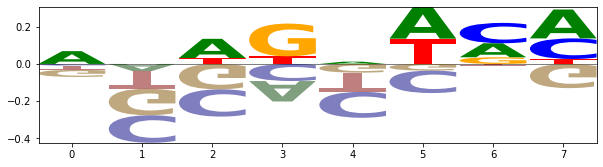

In [315]:
# Full dataset
net = mb.tl.Network().to(device)
optimiser = topti.Adam(net.parameters(), lr=0.0001)
criterion = tnn.BCELoss()
mb.tl.create_logo(net)

In [316]:
# optimiser = topti.Adam(net.parameters(), lr=0.0001)
mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=100)

Epoch:  1, Loss: 1.390
Epoch:  2, Loss: 1.286
Epoch:  3, Loss: 1.185
Epoch:  4, Loss: 1.094
Epoch:  5, Loss: 1.009
Epoch:  6, Loss: 0.934
Epoch:  7, Loss: 0.870
Epoch:  8, Loss: 0.819
Epoch:  9, Loss: 0.779
Epoch: 10, Loss: 0.749
Epoch: 11, Loss: 0.729
Epoch: 12, Loss: 0.717
Epoch: 13, Loss: 0.710
Epoch: 14, Loss: 0.705
Epoch: 15, Loss: 0.702
Epoch: 16, Loss: 0.701
Epoch: 17, Loss: 0.700
Epoch: 18, Loss: 0.700
Epoch: 19, Loss: 0.699
Epoch: 20, Loss: 0.699
Epoch: 21, Loss: 0.699
Epoch: 22, Loss: 0.699
Epoch: 23, Loss: 0.699
Epoch: 24, Loss: 0.699
Epoch: 25, Loss: 0.700
Epoch: 26, Loss: 0.700
Epoch: 27, Loss: 0.699
Epoch: 28, Loss: 0.700
Epoch: 29, Loss: 0.700
Epoch: 30, Loss: 0.700
Epoch: 31, Loss: 0.699
Epoch: 32, Loss: 0.699
Epoch: 33, Loss: 0.699
Epoch: 34, Loss: 0.699
Epoch: 35, Loss: 0.700
Epoch: 36, Loss: 0.699
Epoch: 37, Loss: 0.699
Epoch: 38, Loss: 0.700
Epoch: 39, Loss: 0.700
Epoch: 40, Loss: 0.699
Epoch: 41, Loss: 0.699
Epoch: 42, Loss: 0.699
Epoch: 43, Loss: 0.700
Epoch: 44, 

In [322]:
optimiser = topti.Adam(net.parameters(), lr=0.0001)
mb.tl.train_network(net, train_loader, device, optimiser, criterion, num_epochs=50)

Epoch:  1, Loss: 0.698
Epoch:  2, Loss: 0.698
Epoch:  3, Loss: 0.697
Epoch:  4, Loss: 0.697
Epoch:  5, Loss: 0.697
Epoch:  6, Loss: 0.697
Epoch:  7, Loss: 0.697
Epoch:  8, Loss: 0.697
Epoch:  9, Loss: 0.697
Epoch: 10, Loss: 0.697
Epoch: 11, Loss: 0.698
Epoch: 12, Loss: 0.697
Epoch: 13, Loss: 0.698
Epoch: 14, Loss: 0.697
Epoch: 15, Loss: 0.698
Epoch: 16, Loss: 0.697
Epoch: 17, Loss: 0.697
Epoch: 18, Loss: 0.697
Epoch: 19, Loss: 0.698
Epoch: 20, Loss: 0.698
Epoch: 21, Loss: 0.697
Epoch: 22, Loss: 0.697
Epoch: 23, Loss: 0.697
Epoch: 24, Loss: 0.697
Epoch: 25, Loss: 0.697
Epoch: 26, Loss: 0.697
Epoch: 27, Loss: 0.698
Epoch: 28, Loss: 0.697
Epoch: 29, Loss: 0.697
Epoch: 30, Loss: 0.697
Epoch: 31, Loss: 0.698
Epoch: 32, Loss: 0.697
Epoch: 33, Loss: 0.697
Epoch: 34, Loss: 0.698
Epoch: 35, Loss: 0.697
Epoch: 36, Loss: 0.697
Epoch: 37, Loss: 0.697
Epoch: 38, Loss: 0.697
Epoch: 39, Loss: 0.698
Epoch: 40, Loss: 0.697
Epoch: 41, Loss: 0.697
Epoch: 42, Loss: 0.697
Epoch: 43, Loss: 0.697
Epoch: 44, 

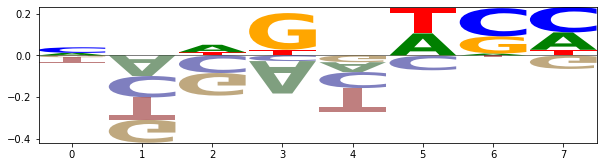

In [323]:
mb.tl.create_logo(net)

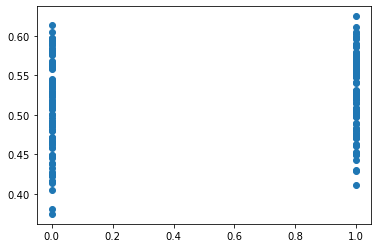

In [324]:
# Test with unseen data (well, even the training data won't work...)
all_targets, all_outputs = [], []
with torch.no_grad():  # we don't need gradients in the testing phase
    for i, batch in enumerate(test_loader):
        # Get a batch and potentially send it to GPU memory.
        inputs, target = batch["input"].to(device), batch["target"].to(device)
        output = net(inputs)
        all_outputs.append(output.squeeze().cpu().detach().numpy())
        all_targets.append(target)
        # print(target)
        # print(output)
plt.scatter(np.array(all_targets), np.array(all_outputs))